In [1]:
import os
import numpy as np
import pandas as pd
from numpy.linalg import norm, inv, svd
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_boston, make_regression
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 4)


Populating the interactive namespace from numpy and matplotlib


In [2]:
def plot(func=None, x=None, y=None, marker=None, color='b', xlabel=None, ylabel=None, title=None, grid=True):
    if func: func(x, y, marker=marker, color=color)
    if xlabel: plt.xlabel(xlabel)
    if ylabel: plt.ylabel(ylabel)
    if title: plt.title(title)
    if grid: plt.grid(grid)

        
def ols(X, y):
    emp_cov = np.matmul(X.T, X)
    y_scaling = X.T.dot(y)
    return inv(emp_cov).dot(y_scaling)

In [3]:
X, y = load_boston(return_X_y=True)
print("Loaded {} samples in R{}".format(X.shape[0], X.shape[1]))


Loaded 506 samples in R13


Loaded 50 samples in R1


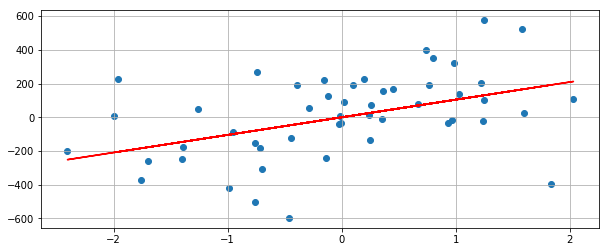

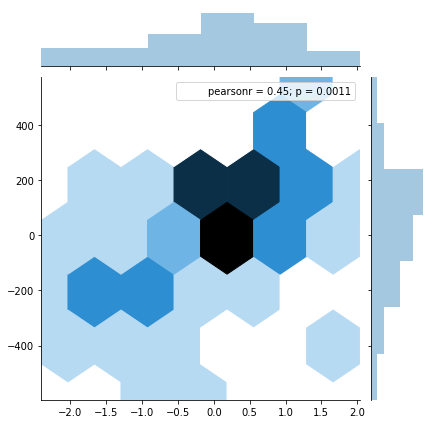

In [8]:
X, y = make_regression(
    n_samples=50,
    n_features=1,
    n_informative=1,
    n_targets=1,
    bias=1.0,
    effective_rank=None,
    tail_strength=0.5,
    noise=250.0,
    shuffle=True,
    coef=False,
    random_state=None
)
print("Loaded {} samples in R{}".format(X.shape[0], X.shape[1]))

ols_weights = ols(X, y)

plt.scatter(X, y)
plt.plot(X, X.dot(ols_weights), 'r')
plt.grid(True)

plt.figure()
sns.jointplot(
    x=X,
    y=y.reshape([-1, 1]),
    kind="hex"
);


# Linear Regression
Linear regression is the "ground floor" of predictive statistics and machine learning. Moving carefully through its theory, and resonating with each of its aspects, makes it easier to extend your understanding to more novel topics without feeling lost. Linear regression models the dependent variable as

$$p(y|x,\theta) = N(y|w^Tx,\sigma^2)$$

The natural "first crack" at estimating $\theta=\hat{w}$ would be the MLE:

$$
\begin{align}
    \hat{w} &= argmax_w\ p(D|\theta) \\
            &= argmax_w\ log\ p(D|\theta) \\
            &= argmax_w\ log\ p(y_0,y_1,...,y_N|x,\theta) \\
\end{align}
$$

That's an unwieldy joint distribution to compute! Because of this, a common (often, invalid) assumption to simplify this computation is made: that each data point is Gaussian i.i.d (independent, drawn from the same Gaussian distribution). Because of this, the joint distribution becomes a _product of the invidual sample probabilities_. Since we are maximizing a _log_ likelihood, we can perform the usual trick of "log(prod(p)) = sum(prod(p))".

$$
\begin{align}
    \hat{w} &= argmax_w\ log\ p(y_0,y_1,...,y_N|x,\theta) \\
            &= argmax_w\ log\ \prod_{i=1}^N p(y_i|x_i,\theta) \\
            &= argmax_w\ \sum_{i=1}^N log(p(y_i|x_i,\theta))
\end{align}
$$

Down to earth: people (and software) tend to approach optimization as a minimization (as opposed to a maximization) problem. Since this is a convex problem, $argmax_w(x) = argmin_w(-x)$, and we can instead minimize the negative of the log likehood (NLL) of the data:

$$
\begin{align}
    \hat{w} &= argmax_w\ \sum_{i=1}^N log[p(y_i|x_i,\theta)] \\
            &= argmin_w\ -\sum_{i=1}^N log[p(y_i|x_i,\theta)] \\
            &= argmin_w\ -\sum_{i=1}^N log[N(y_i|w^Tx_i,\sigma^2)] \\
            &= argmin_w\ -\sum_{i=1}^N log[{(\frac 1 {2\pi\sigma^2})}^{\frac 1 2} exp(-\frac 1 {2\sigma^2} {(y_i-w^Tx_i)}^2)] \\
            &= argmin_w\ -\frac N 2 log[2\pi\sigma^2] + \sum_{i=1}^N \frac 1 {2\sigma^2} {(y_i-w^Tx_i)}^2 \\
    \hat{w} &= argmin_w\ \|\epsilon\|_2^2 \\
    \epsilon_i &= y_i-w^Tx_i \\
\end{align}
$$

So the $\hat{w}$ estimate for what is known as "ordinary least squares" (OLS) is just the $w$ which minimizes the sum of the squared errors between the true labels $y$ and the estimated labels $w^Tx$. The sum of the squared errors (SSE) is also called the "residual sum of squares" (RSS) in the statistical community. In the derivation of $\hat{w}$ below, the constant $\frac 1 2$ is inserted for the sole purpose of cancelling out the constant $2$ created when taking the derivative of a square.

$$
\begin{align}
    \hat{w} &= argmin_w\ \sum_{i=1}^N \frac 1 2 {(y_i-w^Tx_i)}^2 \\
            &= argmin_w\ \frac 1 2 (y-Xw)^T(y-Xw) \\
            &= argmin_w\ \frac 1 2 w^T(X^TX)w-w^T(X^Ty) \\
            &= argmin_w\ g(w) \\
\end{align}
$$

At this point, we see the constant $\frac 1 2$ cancelling with the constant created from the derivative:

$$
\begin{align}
    \frac {\partial} {\partial w} g(w) &= \frac {\partial} {\partial w} \left \{ \frac 1 2 w^T(X^TX)w-w^T(X^Ty) \right \} \\
            &= X^TXw - X^Ty = 0
\end{align}
$$

Which leads us to the "normal equation" for least-squares, solved by the OLS solution for $w$:

$$
\begin{align}
    X^TXw &= X^Ty \\
    \Rightarrow \hat{w} &= w_{OLS} = {(X^TX)}^{-1}X^Ty \\
\end{align}
$$


# Ridge Regression

#### Motivation
The maximum likelihood estimate (MLE) of regression weights can easily overfit. This estimate is simply choosing the parameter set that is the best for modeling the data that you gave it -- what if the data that you gave it is very different from the underlying data distribution that you really are trying to model? The resulting model will miss the mark in areas where your testing data is not well represented by the training data that was used to make the estimate.
 
One way to mitigate this is to impose a prior on the regression weights and then form a MAP estimate of the regression weights. The prior that you impose will constrain the MAP estimate to be similar to the prior until the amount of data causes the posterior to overwhelm the prior.

There are several choices for robust prior distributions to place over the regression weights, but a straightforward one is for them to be zero-mean gaussians. This will prevent the weights from becoming wildly large in order to fit the training data "just right" to maximize the objective.

$$p(w) = \prod_{j=1}^{d}N(w_j\mid0,\tau^2)$$


Notice how $\frac{1}{\tau^2}$ (called the precision of the prior) controls the strengh of your prior. Increasing $\tau$ (the variance on the prior of the weights) allows the posterior estimate to drift farther from the prior mean (of 0 in this case), while decreasing $\tau$ progressively tightens the variance of the prior, making it "harder" for the estimate to drift from the prior. Of course, with enough data the posterior will eventually overwhelm a given prior.

#### Derivation
First, let's incorporate our new prior into the Bayesian representation of the weight vector's distribution.

$$p(w\mid D) = p(D\mid w) * p(w)$$

Using the logarithm allows transforming products into sums (by its monotonicity) and the objective becomes

$$
\begin{align}
\hat w &= argmax_x\,(\mathsf{data\, likelihood\, given\, \hat w}) + (\mathsf{imposed\, prior\, for\, \hat w}) \\
 &= argmax_x\,(\mathsf{data\, likelihood\, given\, \hat w}) + (\mathsf{regularizer\, on\, \hat w}) \\
 &= argmax_x\,(\sum_{i=1}^{N}\log{N(y_i|w_o + w^Tx_i,\sigma^2)}) + (\sum_{j=1}^{d}N(w_j|0,\tau^2)
\end{align}
$$

This can be massaged into a more familiar form, which closely resembles the objective for a support vector machine:

$$
\begin{align}
J(\hat{w}) &= \sum_{i=1}^{N}\log{N(y_i|w_o+w^Tx_i,\sigma^2)} + \sum_{j=1}^{d}\log{N(w_j|0,\tau^2)} \\
           &= \frac{N}{2}\log{2\pi\sigma^2} + \frac{1}{2\sigma^2}\sum_{i=1}^{N}({y - w_o - w^Tx_i})^2 + \frac{N}{2}\log{2\pi\tau^2} + \frac{1}{2\tau^2} \sum_{j=1}^{d}{w_j}^2 \\
           &= \frac{1}{2}\log{2\pi\sigma^2} + \frac{1}{2N\sigma^2}\sum_{i=1}^{N}({y - w_o - w^Tx_i})^2 + \frac{1}{2\tau^2}{\|\hat{w}\|}{^2_2} \\
           &= \frac{1}{N}\sum_{i=1}^{N}({y - (w_o + w^Tx_i)})^2 + \frac{\sigma^2}{\tau^2}{\|\hat{w}\|}{^2_2} \\
           &= \frac{1}{N}\sum_{i=1}^{N}({y - (w_o + w^Tx_i)})^2 + \lambda{\|\hat{w}\|}{^2_2} \\
           &= {MSE}_{\hat{w}} + {Penalty}_{\hat{w}}
\end{align}
$$

In this form, it is straight-forward to interpret the objective function as a combination of the mean-squared error of the function estimate on the training data and a customizable penalty on the complexity of the norm of the function's weight vector. Imposing a higher $\lambda$ coefficient forces $\tau$ to be smaller, which means that the Gaussian prior on the weight vector has a tighter variance. In the limit, $\lambda \rightarrow \infty$ forces $\tau \rightarrow 0$, which makes the Gaussian prior $\hat{w} \rightarrow \vec{0}.$


The minimizer for $J(\hat{w})$ and the corresponding overall function estimate is then

$$
\begin{align}
{\hat{w}}_{ridge} &= ({X^TX + \lambda I_D})^{-1}X^Ty \\
\hat{y} = \hat{f}(x) &= X{\hat{w}}_{ridge} = X({X^TX + \lambda I_D})^{-1}X^Ty
\end{align}
$$

In [5]:
# ols method re-defined to emphasize difference in the ridge solution
def ols(X, y):
    emp_cov = np.matmul(X.T, X)
    y_scaling = X.T.dot(y)
    return inv(emp_cov).dot(y_scaling)

def ridge(X, y, lam):
    feature_dimension = X.shape[1]
    emp_cov = np.matmul(X.T, X)
    y_scaling = X.T.dot(y)
    penalty = lam * np.eye(feature_dimension)
    
    return inv(emp_cov + penalty).dot(y_scaling)


### Ordinary Least-squares Regression vs Ridge Regression

It's been mentioned that the unpenalized MLE can overfit. Let's see that in action, and how ridge regression can be equipped to combat the issue.

First, let's generate a line corrupted by Gaussian noise, with a few severe outliers.


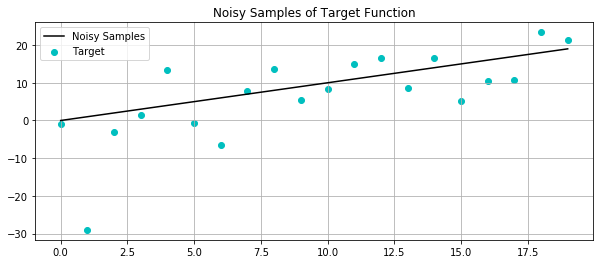

In [6]:
def noisy_func_with_outliers(n_samples=20, noise_std=1, n_outliers=None):
    # default args
    n_outliers = n_outliers or n_samples // 4
    
    # set the weights
    w = np.ones(n_samples).astype(int)
    
    # add noise to the weights
    noise = np.random.normal(scale=noise_std, size=n_samples)
    outlier_indices = np.random.choice(w, size=n_outliers)
    noise[outlier_indices] *= 5
    
    # return noisy samples of the function
    return np.arange(len(w)) * w + noise

n_samples = 20
x = range(n_samples)
noisy_samples = noisy_func_with_outliers(
    n_samples=n_samples,
    noise_std=6,
    n_outliers=5
)

plot(plt.scatter, x, noisy_samples, marker='o', color='c', title="Noisy Samples of Target Function")
plot(plt.plot, x, x, color='k')
plt.legend(["Noisy Samples", "Target"])


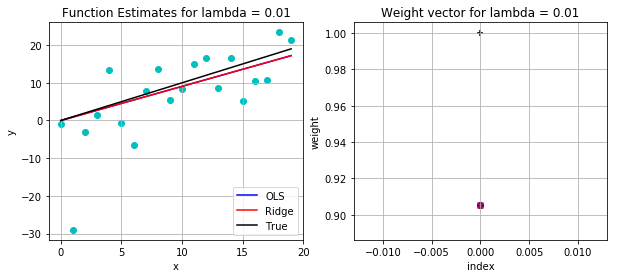

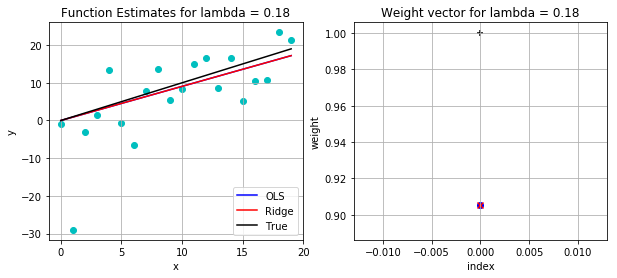

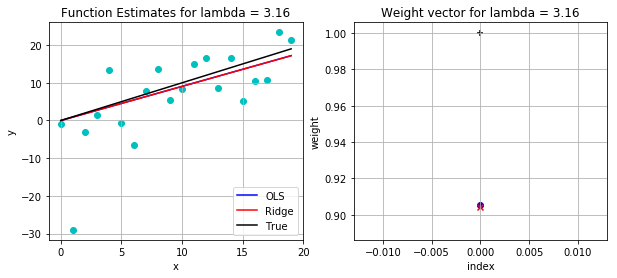

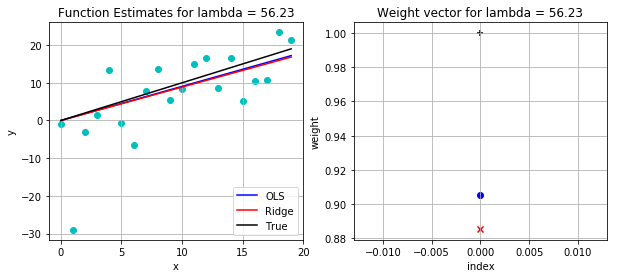

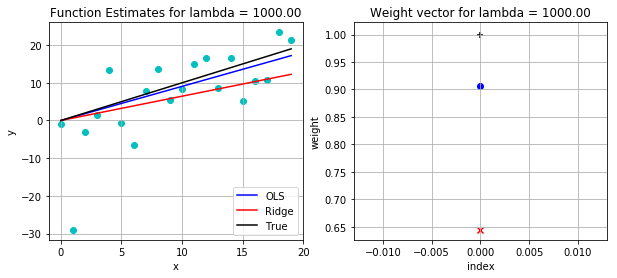

In [7]:
X = np.reshape(x, [-1, 1])
y = noisy_samples
y_true = x
d = X.shape[1]

regularization_coeffs = np.logspace(-2, 3, 5)
df = pd.DataFrame([], columns=["penalty", "mse_ridge"])
df["penalty"] = regularization_coeffs
for reg_penalty in regularization_coeffs:
    w_ols = ols(X, y)
    w_ridge = ridge(X, y, reg_penalty)
    y_ols = X.dot(w_ols)
    y_ridge = X.dot(w_ridge)
    df.loc[df["penalty"] == reg_penalty, "mse_ridge"] = mean_squared_error(y_true, y_ridge)

    plt.figure()
    plt.subplot(1, 2, 1)
    plot(plt.scatter, X, y, color='c', marker='o', xlabel='x', ylabel='y',
         title="Function Estimates for lambda = {:.2f}".format(reg_penalty))
    plot(plt.plot, X, y_ols, color='b')
    plot(plt.plot, X, y_ridge, color='r')
    plot(plt.plot, X, X, color='k')
    plt.legend(["OLS", "Ridge", "True"])
    
    plt.subplot(1, 2, 2)
    plot(plt.scatter, range(d), w_ols, color='b', marker='o', xlabel='index', ylabel='weight',
         title="Weight vector for lambda = {:.2f}".format(reg_penalty))
    plot(plt.scatter, range(d), w_ridge, color='r', marker='x')
    plot(plt.scatter, 0, 1, color='k', marker='+')


,penalty,mse_ridge,mse_ols,Prior Helped
0,0.010000,1.10457,1.10448,False
1,0.177828,1.106,1.10448,False
2,3.162278,1.13169,1.10448,False
3,56.234133,1.62544,1.10448,False
4,1000.000000,15.6079,1.10448,False


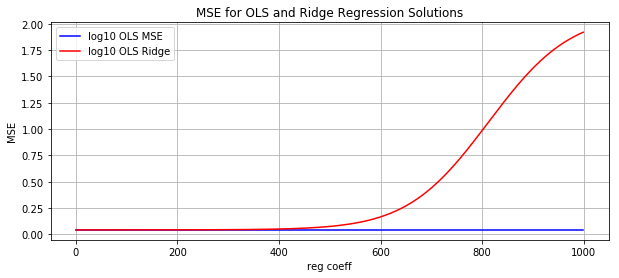

In [8]:
df["mse_ols"] = mean_squared_error(y_true, y_ols)
df["Prior Helped"] = df["mse_ridge"] < df["mse_ols"]

n_coeffs = 1000
penalties = np.logspace(-2, 4, n_coeffs)
all_mse_ridge = np.empty(n_coeffs)
all_mse_ridge = np.array([
    mean_squared_error(y_true, X.dot(ridge(X, y, penalty)))
    for penalty in penalties
], dtype=float)
all_mse_ols = mean_squared_error(y_true, y_ols) * np.ones(n_coeffs)

plot(plt.plot, range(n_coeffs), list(map(np.log10, all_mse_ols)), color='b', xlabel='reg coeff', ylabel='MSE',
    title='MSE for OLS and Ridge Regression Solutions')
plot(plt.plot, range(n_coeffs), list(map(np.log10, all_mse_ridge)), color='r')
plt.legend(["log10 OLS MSE", "log10 OLS Ridge"])

df


### TODO: Connect the ridge regression objective to the soft margin hyperplane objective
.
.
.
.


### Connecting Ridge Regression to PCA

TODO words and equations


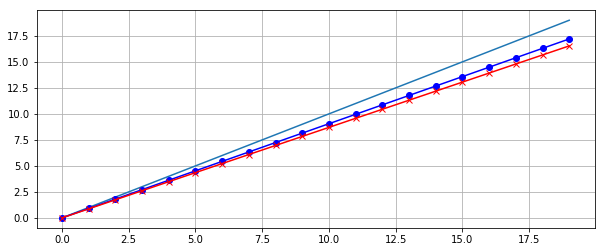

In [9]:
def ols2(X, y):
    U, s, V = svd(X, full_matrices=0)
    S = np.diag(s)
    return U.dot(U.T.dot(y))


def ridge2(X, y, penalty):
    U, s, V = svd(X, full_matrices=0)
    
    # form a diagonal shrinkage matrix, which shrinks towards 0 the
    # contributions of components with small singular values (high posterior variance)
    s2 = s * s
    s = s2 / (s2 + penalty)
    S = np.diag(s)
    
    return U.dot(S.dot(U.T.dot(y)))

y1 = X.dot(ols(X, y))
y2 = ridge2(X, y, 100)

plt.plot(range(len(y)), range(len(y)))
plt.plot(range(len(y1)), y1, color='b', marker='o')
plt.plot(range(len(y2)), y2, color='r', marker='x')
plt.legend(["True", "OLS Approx.", "Ridge Approx."])
plt.grid(True)


### Bayesian Linear Regression

